#### Project - Monthly Armed Robberies in Boston

##### Overview:
1. Problem Description
2. Test Harness
3. Persistence
4. Data Analysis
5. ARIMA models
6. Model Validation

These are the general steps that can be followed for any time series forecasting project and is not exhaustive, we can curate it as per the project requirement.

####  1. Problem Description:
   The problem is to predict number of monthly armed robberies in USA. The dataset provides the number of monthly armed robberies in Boston from Jan 1966 to Oct 1975, or just            under 10 years of data. The values are a count and there are 118 observations. The dataset is credited to McCleary and Hay(1980).

#### 2. Test Harness:
   We must develop a test harness to investigate the data and evaluate candidate models. This involves two steps, 1. Defining a validation dataset, 2. Developing a method for            model evaluation. We will withhold the last 1 year of data as a validation dataset from Oct 1974.

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/sai_vyas/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
series = pd.read_csv('/home/sai_vyas/Documents/all_datasets/monthly-robberies.csv', header=0, index_col=0, parse_dates=[0],squeeze=True)
series

Month
1966-01-01     41
1966-02-01     39
1966-03-01     50
1966-04-01     40
1966-05-01     43
             ... 
1975-06-01    316
1975-07-01    398
1975-08-01    394
1975-09-01    431
1975-10-01    431
Name: Robberies, Length: 118, dtype: int64

In [3]:
split_point = len(series) - 12 #Keeping last 12 months aside for validaton
train, test = series[0:split_point], series[split_point:]
print('Train {}, Test {}'.format(len(train),len(test)))
train.to_csv('train.csv')
test.to_csv('test.csv')

Train 106, Test 12


 Train: Observations from January 1966 to October 1974 (106 observations) ;
 Test: Observations from November 1974 to October 1975 (12 observations)

#### Model evaluation
It is done on training dataset & involves 'Performance Measure' and 'Test Strategy'.
Performance Measure - Root mean squared error (RMSE). This will give weights to predictions that are grossly wrong & will have same units as original data. All transformations must be reversed before computing RMSE to make performance between various metrics comparable.

In [4]:
from sklearn.metrics import mean_squared_error
def rmse(test, predictions):
    mse = mean_squared_error(test, predictions)
    rmse = (mse)**0.5
    return rmse

#### Validation strategy
Models will be evaluated using walk-forward validation, because a rolling forecast type model is required from the problem definition. One-step forecasts are needed given all available data. Walk-forward validaton will work as follows:
1. First 50% of dataset is for training the model
2. Next 50% is for validation & iteration
3. For each step in validation set,
    * A model will be trained
    * A one-step prediction is made & stored for later evaluation
    * Actual observation from the validation set is added to training set for next iteration
4. Predictions made during each iteration are evaluated & RMSE is computed

In [5]:
#prepare data
X = series.values.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

#### 3. Persistence
Baseline model - naive forecast or persistence model. Previous time step is used to predict next time step.

In [6]:
#evaluate a persistence model
#walk-forward validation
history = [x for x in train]
predictions = []
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted = {}, Expected = {}'.format(yhat, obs))
# performance report
rmse = rmse(test, predictions)
print('RMSE is {}'.format(rmse))

>Predicted = 174.0, Expected = 178.0
>Predicted = 178.0, Expected = 136.0
>Predicted = 136.0, Expected = 161.0
>Predicted = 161.0, Expected = 171.0
>Predicted = 171.0, Expected = 149.0
>Predicted = 149.0, Expected = 184.0
>Predicted = 184.0, Expected = 155.0
>Predicted = 155.0, Expected = 276.0
>Predicted = 276.0, Expected = 224.0
>Predicted = 224.0, Expected = 213.0
>Predicted = 213.0, Expected = 279.0
>Predicted = 279.0, Expected = 268.0
>Predicted = 268.0, Expected = 287.0
>Predicted = 287.0, Expected = 238.0
>Predicted = 238.0, Expected = 213.0
>Predicted = 213.0, Expected = 257.0
>Predicted = 257.0, Expected = 293.0
>Predicted = 293.0, Expected = 212.0
>Predicted = 212.0, Expected = 246.0
>Predicted = 246.0, Expected = 353.0
>Predicted = 353.0, Expected = 339.0
>Predicted = 339.0, Expected = 308.0
>Predicted = 308.0, Expected = 247.0
>Predicted = 247.0, Expected = 257.0
>Predicted = 257.0, Expected = 322.0
>Predicted = 322.0, Expected = 298.0
>Predicted = 298.0, Expected = 273.0
>

#### 4. Data Analysis
Summary statistics

In [7]:
series.describe()

count    118.000000
mean     196.288136
std      128.043602
min       29.000000
25%       85.500000
50%      166.000000
75%      296.750000
max      500.000000
Name: Robberies, dtype: float64

The large standard deviation(spread from the mean) can make it difficult to do high accurate predictions if it's random (not systematic)

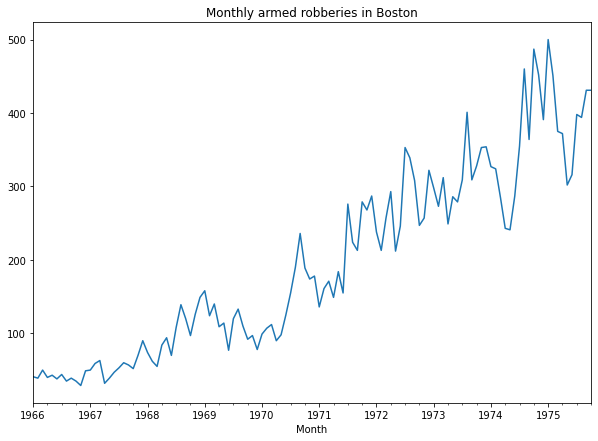

In [8]:
#line plot
plt.figure(figsize = (10,7))
plt.title('Monthly armed robberies in Boston')
series.plot()
plt.show()

Observations:
* Increase in trend of robberies over time.
* No outliers are appeared.
* Relatively large fluctuations up & down in the later years than prior years.

This trend means the dataset is almost certainly non-stationary and apparent change in fluctuation may also contribute. We might see a benefit in modeling the trend and removing it from the time series. Altenatively, we can use differencing to make series stationary for modeling. We may need two levels of differencing if there's a growth in trend in fluctuations in later years.

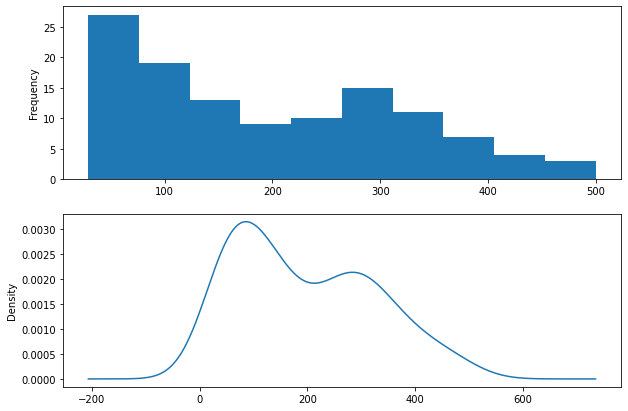

In [9]:
#density plot
plt.figure(figsize=(10,7))
plt.subplot(211)
series.plot(kind='hist', bins =10)
plt.subplot(212)
series.plot(kind='kde')
plt.show()

Observations:
* The distribution in not Gaussian
* The distribution is left shifted & may be exponential or double Gaussian

We may see some benefit in exploring power transforms of the data prior to modeling.

Box & whisker plots -
We can group the monthly data by year and get an idea of the spread of observations for each year and how this may be changing.It's interesting to see how rest of the distribution is changing.The plot below groups the observations by year and creates one box and whisker plot for each year of observations. The last year (1974) only contains 10 months and may not be a useful comparison with the other 12 months of observations in the other years. Therefore only data between 1966 and 1973 was plotted.

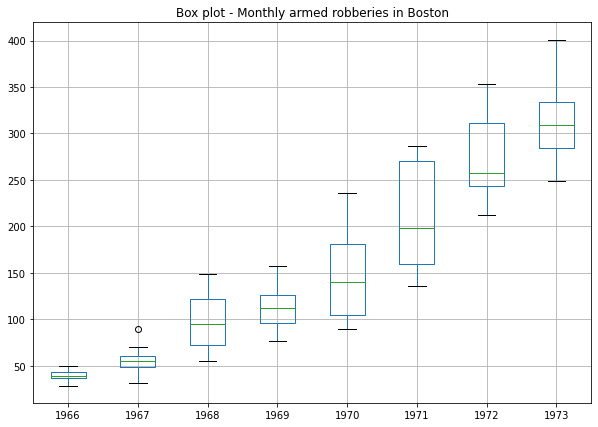

In [10]:
#boxplot
from pandas import Grouper
from pandas import DataFrame
groups = series['1966':'1973'].groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot(figsize=(10,7))
plt.title('Box plot - Monthly armed robberies in Boston')
plt.show()

Observations:
* Year to year fluctuations are not systematic and hard to model since there's high randomness in fluctuations
* We can benefit from clipping first 2 years of data from modeling if it's indeed quite different

#### Auto Regressive Integrated Moving Average Models ( ARIMA )

We will develop ARIMA model as follows:
* Develop a manually configured ARIMA model
* Use a grid search of ARIMA to find optimized model
* Analysis of forecast residual errors to evaluate any bias in the model
* Explore improvements to the model using power transforms

Below is the code to make the time series stationary & using a statistical test to confirm stationarity

In [11]:
# statistical test for the stationarity of time series
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
# create a differenced time series
def difference(dataset):
    diff = []
    for i in range(len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return Series(diff)
X = series.values
# difference data
stationary = difference(X)
stationary.index = series.index[0:]
# checking stationarity
result = adfuller(stationary)
print('ADF Statistic = {}'.format(result[0]))
print('p-value = {}'.format(result[1]))
print('Critical values = ')
for key, value in result[4].items():
    print( ' \t%s: %.3f ' % (key, value))
# save
stationary.to_csv('stationary.csv')

ADF Statistic = -7.194874946453263
p-value = 2.4494067041712647e-10
Critical values = 
 	1%: -3.493 
 	5%: -2.889 
 	10%: -2.581 


This suggests that atleast one level differencing is required. The d parameter in our ARIMA model should be atleast 1. Next step is to select lag values for Auto Regression(AR) and Moving Average (MA) parameters p & q respectively. We can do this by analysing Auto correlation & partial auto correlation functions ACF & PACF

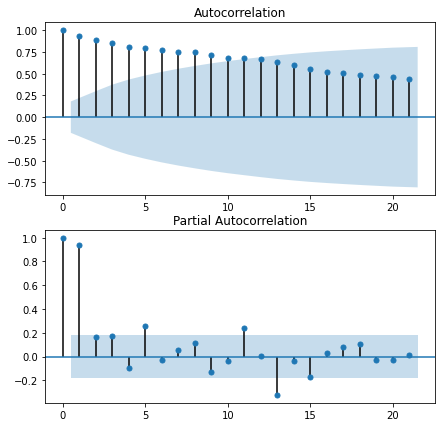

In [12]:
# ACF & PACF plots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(7,7))
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.show()

Observations:
* ACF shows a significant lag for 11 months
* PACF shows a significant lag for perhaps 2 months
* Both ACF & PACF shows a drop off at same point, suggesting mixing of AR & MA
A good starting point for p & q is 1 or 2.

This quick analysis of suggests an ARIMA(11,1,2) on the raw data may be a good starting point. Experimentation shows that this configuaration of ARIMA doesn't converge and results in errors by the underlying library, as do similary large AR values. Below is the performance of ARIMA model on test harness.

In [13]:
# evaluate manually configured ARIMA model
#walk-forward validation
history = [x for x in train]
predictions = []
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print( ' >Predicted=%.3f, Expected=%3.f ' % (yhat, obs))
# report performance
rmse = (mean_squared_error(test, predictions)) ** 0.5
print( ' RMSE: %.3f ' % rmse)

 >Predicted=184.846, Expected=178 
 >Predicted=183.763, Expected=136 
 >Predicted=146.180, Expected=161 
 >Predicted=171.279, Expected=171 
 >Predicted=170.196, Expected=149 
 >Predicted=154.425, Expected=184 
 >Predicted=185.708, Expected=155 
 >Predicted=157.284, Expected=276 
 >Predicted=245.280, Expected=224 
 >Predicted=222.242, Expected=213 
 >Predicted=219.698, Expected=279 
 >Predicted=261.506, Expected=268 
 >Predicted=264.287, Expected=287 
 >Predicted=282.759, Expected=238 
 >Predicted=255.843, Expected=213 
 >Predicted=235.189, Expected=257 
 >Predicted=257.622, Expected=293 
 >Predicted=280.345, Expected=212 
 >Predicted=235.564, Expected=246 
 >Predicted=255.342, Expected=353 
 >Predicted=318.613, Expected=339 
 >Predicted=310.335, Expected=308 
 >Predicted=306.789, Expected=247 
 >Predicted=270.213, Expected=257 
 >Predicted=283.318, Expected=322 
 >Predicted=316.063, Expected=298 
 >Predicted=294.466, Expected=273 
 >Predicted=289.635, Expected=312 
 >Predicted=314.759,

Our RMSE of 51.007 is less than baseline persistence model. Although, this is a good start, we may get better results with a better configured ARIMA model.

#### Grid Search ARIMA Hyperparameters
Many ARIMA configurations are unstable in this dataset, but there may be other hyperparamenters that result in well performing model. We will tune values of p, d, q with various combinations that do not result in error. We will use Grid Search method that searches for values in a subset of integers. We will search for following values.

* p = 0 to 12
* d = 0 to 3
* q = 0 to 12

This is (13 x 4 x 13), or 676 runs of the test harness and will take some time to execute.

In [14]:
from math import sqrt

# grid search ARIMA parameters for time series
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
evaluate_arima_model(series, (0,1,2)) # Testing the function with prior ARIMA configuration


51.00727884433921

The following code is for Grid Search hyperparameters for choosing the best configuration for ARIMA & RMSE for the same. Since, 676 runs increase the runtime of this notebook immensly, we'll comment the code. If needed to test run, you can remove the comment, run it and the best configuration will be ARIMA(0 ,1, 2) and RMSE=51.007. Its the same as our baseline configuration. Hence, no point of tuning hyperparameters, as there's no improvement from the previous config.

In [16]:
# evaluate combinations of p, d and q values for an ARIMA model
#def evaluate_models(series, p_values, d_values, q_values):
#    series = series.astype('float32')
#    best_score, best_cfg = float("inf"), None
#    for p in p_values:
#        for d in d_values:
#            for q in q_values:
#                order = (p,d,q)
#                try:
#                    rmse = evaluate_arima_model(series, order)
#                    if rmse < best_score:
#                        best_score, best_cfg = rmse, order
#                    print( ' ARIMA%s RMSE=%.3f ' % (order,rmse))
#                except:
#                    continue
#    print( ' Best ARIMA%s RMSE=%.3f ' % (best_cfg, best_score))

                    
# load dataset
#series = Series.from_csv('/home/sai_vyas/Documents/all_datasets/monthly-robberies.csv')
# We already loaded dataset in the begining, this is just to confirm the variable name once again.
# evaluate parameters
#p_values = range(0,13)
#d_values = range(0, 4)
#q_values = range(0,13)

import warnings
warnings.filterwarnings('ignore')
#evaluate_models(series.values, p_values, d_values, q_values)"""

#### Review residual errors

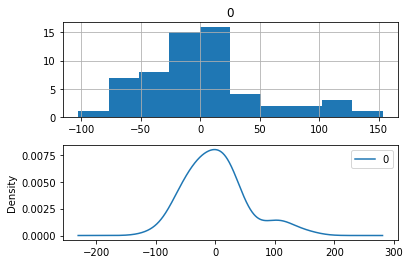

In [27]:
# observation
obs = test[i]
history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind= 'kde' , ax=plt.gca())

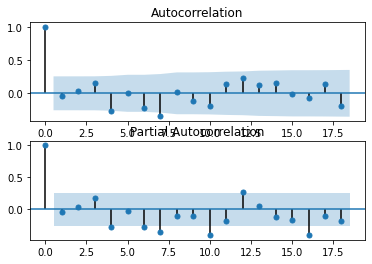

In [28]:
plt.figure()
plt.subplot(211)
plot_acf(residuals, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, ax=plt.gca())
plt.show()

#### Box-Cox Transformed dataset
The Box-Cox transform is a method that is able to evaluate a suite of power transforms,
including, but not limited to, log, square root, and reciprocal transforms of the data. The
example below performs a log transform of the data and generates some plots to review the
effect on the time series.

 Lambda: 0.316780 


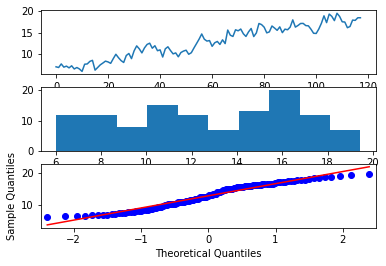

In [31]:
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
transformed, lam = boxcox(X)
print( ' Lambda: %f ' % lam)
plt.figure(1)
# line plot
plt.subplot(311)
plt.plot(transformed)
# histogram
plt.subplot(312)
plt.hist(transformed)
# q-q plot
plt.subplot(313)
qqplot(transformed, line='r', ax=plt.gca())
plt.show()

In [33]:
# invert Box-Cox transform
from math import log
from math import exp
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

In [36]:
# evaluate ARIMA with box-cox transformed time series
# walk-forward validation
history = [x for x in train]
predictions = []
for i in range(len(test)):
    # transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1
    # predict
    model = ARIMA(transformed, order=(0,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print( ' >Predicted=%.3f, Expected=%3.f ' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print( ' RMSE: %.3f ' % rmse)

 >Predicted=184.411, Expected=178 
 >Predicted=186.637, Expected=136 
 >Predicted=154.274, Expected=161 
 >Predicted=175.673, Expected=171 
 >Predicted=174.165, Expected=149 
 >Predicted=159.916, Expected=184 
 >Predicted=187.302, Expected=155 
 >Predicted=161.653, Expected=276 
 >Predicted=244.354, Expected=224 
 >Predicted=212.415, Expected=213 
 >Predicted=221.180, Expected=279 
 >Predicted=262.629, Expected=268 
 >Predicted=260.125, Expected=287 
 >Predicted=283.321, Expected=238 
 >Predicted=255.089, Expected=213 
 >Predicted=241.694, Expected=257 
 >Predicted=267.304, Expected=293 
 >Predicted=286.368, Expected=212 
 >Predicted=237.871, Expected=246 
 >Predicted=265.184, Expected=353 
 >Predicted=323.318, Expected=339 
 >Predicted=318.584, Expected=308 
 >Predicted=315.816, Expected=247 
 >Predicted=279.561, Expected=257 
 >Predicted=289.125, Expected=322 
 >Predicted=323.738, Expected=298 
 >Predicted=305.205, Expected=273 
 >Predicted=297.093, Expected=312 
 >Predicted=322.521,

RMSE improved marginally to 50.758. It may or may not be statistically different.

#### Model validation
After models have been developed and a final model selected, it must be validated and finalized. Validation is an optional part of the process, but one that provides a last check to ensure we have not fooled or lied to ourselves. This includes the following:
* Finalize model : Train and save the final model
* Model prediction : Load the finalized model and make a prediction
* Validate model: Load and validate final model

In [41]:
# finalize model and save to file with workaround
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
from statsmodels.tsa.arima_model import ARIMAResults
import numpy

# transform data
transformed, lam = boxcox(X)
# fit model
model = ARIMA(transformed, order=(0,1,2))
model_fit = model.fit(disp=0)
# save model
model_fit.save( 'model.pkl' )
numpy.save( 'model_lambda.npy' , [lam])

# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

model_fit = ARIMAResults.load( 'model.pkl' )
lam = numpy.load( 'model_lambda.npy' )
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
print( ' Predicted: %.3f ' % yhat)

 Predicted: 424.525 


RMSE: 50.758


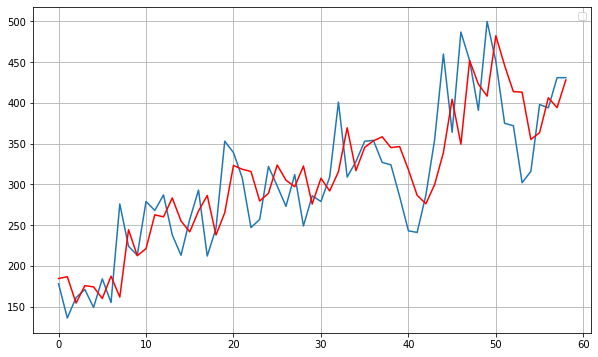

In [58]:
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
plt.figure(figsize=(10,6))
plt.legend(test, predictions, loc='best')
plt.plot(test)
plt.plot(predictions, color='red')
plt.grid(True)
plt.show()

### Conclusion

Although ARIMA model performs decently better than persistence model, there's still a lot of room for improvement. Family of exponential smoothing methods too result in similar predictions. One that is interesting is to use Recurrent Neural Networks & specifically, Long Short Term Memory Cells ( LSTM ) which is proved to be best performing architecture especially for the sequence data. Let's improvise on it shortly.